# VowPal WABBIT

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. Стахостический градиентный спуск
## 1.1 SGD

In [2]:
path_to_all_data = 'datasets/spooky-vw-tutorial/'
data_demo = pd.read_csv(os.path.join(path_to_all_data, 'weights_heights.csv'))

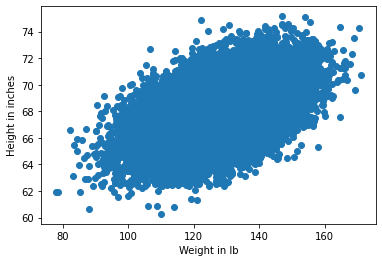

In [5]:
plt.scatter(data_demo['Weight'], data_demo['Height'])
plt.xlabel('Weight in lb')
plt.ylabel('Height in inches');

# 1.2 Online learning

# 2.1 Label Encoding

In [13]:
df = pd.read_csv(os.path.join(path_to_all_data, 'bank_train.csv'))
labels = pd.read_csv(os.path.join(path_to_all_data, 'bank_train_target.csv'), header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


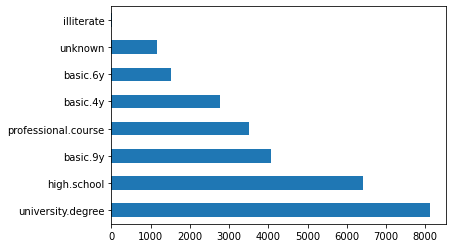

In [14]:
df['education'].value_counts().plot.barh();

In [15]:
label_encoder =LabelEncoder()

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


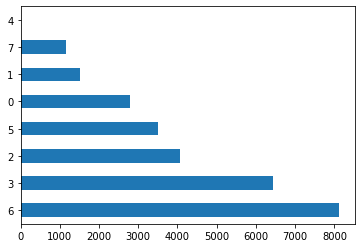

In [16]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [17]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [18]:
df.loc[1].job - df.loc[2].job

-1.0